# Find Teleconnections (precursor regions) via correlation maps 

In [1]:
import os
from RGCPD import RGCPD
from RGCPD import BivariateMI
from RGCPD import class_BivariateMI, functions_pp, core_pp, plot_maps, find_precursors
from IPython.display import Image
import numpy as np
import pandas as pd
import utils_sem, gradients

/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: No module named 'networkx'
  warnings.warn(str(e))


In [2]:
path_obs_data = '/data/volume_2/observational/'

target = core_pp.import_ds_lazy(os.path.join(path_obs_data, 'chrips_1981-2021_target_new_left.nc'))

df_target = target['spatial_mean_raw'].to_dataframe()


# define input by filling list_of_name_path: 
# format list_of_name_path = [('TVname', 'TVpath'), ('prec_name', 'prec_path')]
list_of_name_path = [('', df_target.shift(-14)),
                    ('sst', os.path.join(path_obs_data, 'raw', 'era5_sst_1959-2021_1_12_daily_2.0deg.nc')),
                    ('t2m_gr', os.path.join(path_obs_data, 'raw', 'era5_t2m_1959-2021_1_12_daily_2.0deg.nc')),
                    ('t2m', os.path.join(path_obs_data, 'raw', 'era5_t2m_1959-2021_1_12_daily_2.0deg.nc')),
                    ('z500', os.path.join(path_obs_data, 'raw', 'era5_z_500hpa_1959-2021_1_12_daily_2.0deg.nc'))]

# define analysis:
list_for_MI = [BivariateMI(name='sst', 
                           alpha=.01, FDR_control=True, lags=np.array([1]), 
                           distance_eps=700, min_area_in_degrees2=5, lag_as_gap=False),
              BivariateMI(name='t2m_gr', 
                           alpha=.01, FDR_control=True, lags=np.array([1]), 
                           distance_eps=700, min_area_in_degrees2=5, lag_as_gap=False),
              # BivariateMI(name='t2m', 
              #              alpha=.01, FDR_control=True, lags=np.array([1]), 
              #              distance_eps=700, min_area_in_degrees2=5, lag_as_gap=False),
               BivariateMI(name='z500', 
                           alpha=.01, FDR_control=True, lags=np.array([1]), 
                           distance_eps=700, min_area_in_degrees2=5, lag_as_gap=False)]



# Time-handling subseasonal mode
4-week (28 day) mean periods that fall within OND period

In [3]:
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           tfreq=28, # <- subseasonal forecasting mode, all data will be aggregated to 10-day means
           start_end_TVdate=('10-01', '12-31'), # <- defining target period 
           start_end_year=(1981, 2020),
           path_outmain='./output_lorentz')

In [4]:
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)

Loaded pre-processed data of sst

Loaded pre-processed data of t2m_gr

Loaded pre-processed data of t2m

Loaded pre-processed data of z500



Option for pp_precursors to vary pre-processing of datasets by given a list as an argument:
An example: detrend=[True, {'sm1':False, 'sm2':False}]. This input means that default argument is True, except the variables sm1 and sm2 got a different argument. The precursor names sm1 and sm2 should refer to the names given in list_of_name_path.

### Post-processing Target Variable

Start linear detrending ...
Done
Visual test on 0th observationusing absolute anomalies w.r.t. climatology of smoothed concurrent day accross years
original tfreq of imported response variable is converted to desired 28 (daily) means


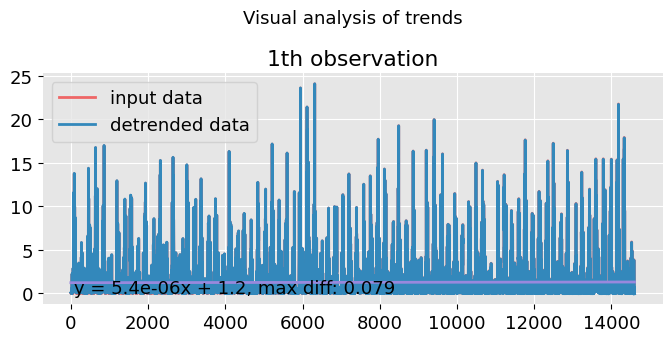

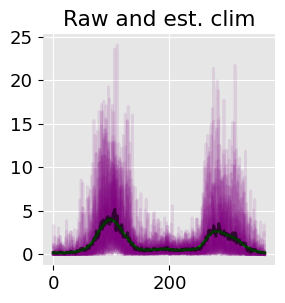

In [5]:
rg.pp_TV(detrend=True, anomaly=True)

In [6]:
rg.traintest(method='leave_2', gap_prior=0, gap_after=0, seed=2)
# rg._get_testyrs()[0] # see test years

In [7]:
rg.calc_corr_maps(['sst', 't2m', 'z500'])


sst - calculating correlation maps
Progress traintest set 100%, trainsize=(114dp, 95%)


z - calculating correlation maps
Progress traintest set 100%, trainsize=(114dp, 95%)



In [8]:
# Calculate gradient of t2m
t2m = core_pp.import_ds_lazy(rg.list_precur_pp[1][1])
dx = 30
t2m_grd = gradients.compute_gradient_along_dim(t2m, 'longitude', dx)
filepath_grad = os.path.join(path_obs_data, 'raw', f'era5_t2m_1959-2021_1_12_daily_2.0deg_grad_{dx}.nc')
t2m_grd.to_netcdf(filepath_grad)
precur = rg.list_for_MI[1]
precur.filepath = filepath_grad

In [10]:
precur.load_and_aggregate_precur(rg.kwrgs_load)
precur.load_and_aggregate_ts(rg.df_splits.copy())
corr_xr, pval_xr = precur.bivariateMI_map(precur.precur_arr, rg.df_splits, rg.df_fullts)
find_precursors.add_info_precur(precur, corr_xr, pval_xr)


t2m - calculating correlation maps
Progress traintest set 100%, trainsize=(114dp, 95%)



Plotting sst
Plotting Corr maps sst, split 0, lag 1
Plotting t2m_gr
Plotting Corr maps t2m, split 0, lag 1
Plotting z500
Plotting Corr maps z, split 0, lag 1


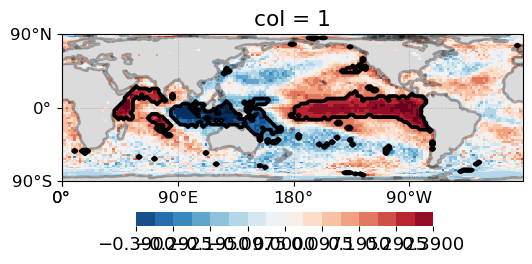

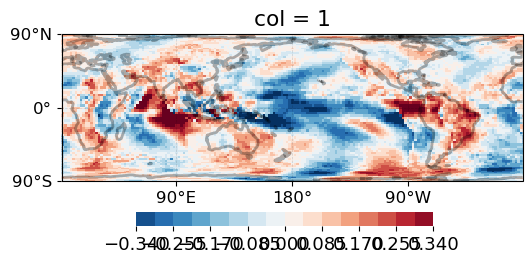

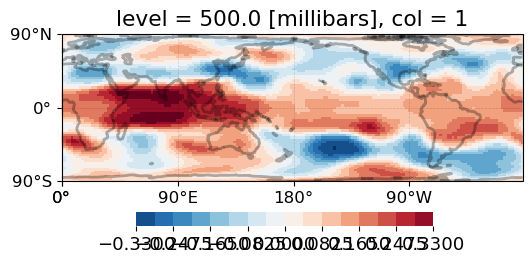

In [11]:
rg.plot_maps_corr()

In [12]:
rg.cluster_list_MI()


No significantly correlating gridcells found for t2m_gr.



Plotting Corr maps sst_labels_init, split 0, lag 1
no t2m_gr regions that pass distance_eps and min_area_in_degrees2 citeria
no z500 regions that pass distance_eps and min_area_in_degrees2 citeria


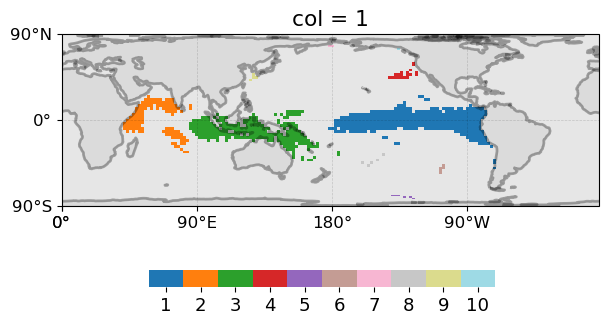

In [13]:
rg.quick_view_labels(mean=True) 

In [14]:
rg.get_ts_prec()


Getting MI timeseries
No timeseries retrieved for t2m_gr on split 0
No timeseries retrieved for z500 on split 0
No timeseries retrieved for t2m_gr on split 1
No timeseries retrieved for z500 on split 1
No timeseries retrieved for t2m_gr on split 2
No timeseries retrieved for z500 on split 2
No timeseries retrieved for t2m_gr on split 3
No timeseries retrieved for z500 on split 3
No timeseries retrieved for t2m_gr on split 4
No timeseries retrieved for z500 on split 4
No timeseries retrieved for t2m_gr on split 5
No timeseries retrieved for z500 on split 5
No timeseries retrieved for t2m_gr on split 6
No timeseries retrieved for z500 on split 6
No timeseries retrieved for t2m_gr on split 7
No timeseries retrieved for z500 on split 7
No timeseries retrieved for t2m_gr on split 8
No timeseries retrieved for z500 on split 8
No timeseries retrieved for t2m_gr on split 9
No timeseries retrieved for z500 on split 9
No timeseries retrieved for t2m_gr on split 10
No timeseries retrieved for z5

From the correlation (BivariateMI) map, the timeseries are named according the format:
{lag}..{region label}..{precursor name}, where precursor name is defined in list_of_name_path. 

## Train-test cross-validation and Response Variable mask handling

- The different train-test folds are organized in the first level index.
- Each fold contains precursor timeseries that were extracted from only training data.
- The Training data is specified by the TrainIsTrue mask.
- The Response Variable mask defined the dates to predict 
- The RV_mask the anker for lag shifting the precursors.

The last two columns should be always present. 
- The RV_mask is defined by the start_end_TVdate.
- The TrainIsTrue is defined by the method for cross-validation.


# Forecasting pipeline

In [15]:
from RGCPD.forecasting import func_models as fc_utils
from RGCPD.forecasting.stat_models_cont import ScikitModel
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegressionCV

model = ScikitModel(LogisticRegressionCV, verbosity=0)
kwrgs_model = {'kfold':5,
               'scoring':'neg_brier_score',
               'Cs':30}

# get original binary
target_ts = target['binary'].sel(time=rg.df_fullts.index).to_dataframe()
target_ts = pd.concat([target_ts]*rg.n_spl, keys=range(rg.n_spl)) # make it align with train-test multi-index


BSS = fc_utils.ErrorSkillScore(constant_bench=0.33).BSS
score_func_list = [BSS, fc_utils.metrics.roc_auc_score]


In [16]:
keys = rg.df_data.columns[1:-2]
# keys = [k for k in keys if 'sst' in k]
# keys = [k for k in keys if int(k.split('..')[1]) in [1,3]]

out = rg.fit_df_data_ridge(target=target_ts,
                           keys=keys,
                           df_data=rg.df_data.copy(),
                           fcmodel=model,
                           kwrgs_model=kwrgs_model,
                           transformer=fc_utils.standardize_on_train,
                           tau_min=1, tau_max=1)
predict, weights, model_lags = out

df_train_m, df_test_s_m, df_test_m, df_boot = fc_utils.get_scores(predict,
                                                                 rg.df_data.iloc[:,-2:],
                                                                 score_func_list,
                                                                 n_boot = 100,
                                                                 score_per_test=False,
                                                                 blocksize=1,
                                                                 rng_seed=1)
lag = 1
print(model.scikitmodel.__name__, '\n', f'Test score at lag {lag}\n',
      'BSS {:.2f}\n'.format(df_test_m.loc[0].loc[lag].loc['BSS']),
      'AUC {:.2f}'.format(df_test_m.loc[0].loc[lag].loc['roc_auc_score']),
      '\nTrain score\n',
      'BSS {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['BSS']),
      'AUC {:.2f}'.format(df_train_m.mean(0).loc[lag]['roc_auc_score']))

LogisticRegressionCV 
 Test score at lag 1
 BSS 0.11
 AUC 0.73 
Train score
 BSS 0.20
 AUC 0.79


In [25]:
keys = [k for k in rg.df_data.columns[:-2] if 'sst' in k]
keys = [k for k in keys if int(k.split('..')[1]) in [1,3]]
# calculate difference between timeseries
df_grad = (rg.df_data[keys[0]] - rg.df_data[keys[1]]).to_frame('grad')
other_keys = [k for k in rg.df_data.columns[1:-2] if k not in ['1..1..sst', '1..3..sst']]
df_grad = df_grad.merge(rg.df_data[other_keys], left_index=True, right_index=True)
# add traintest masks
df_grad = df_grad.merge(rg.df_splits, left_index=True, right_index=True)



out = rg.fit_df_data_ridge(target=target_ts,
                           keys=None,
                           df_data=df_grad,
                           fcmodel=model,
                           kwrgs_model=kwrgs_model,
                           transformer=fc_utils.standardize_on_train,
                           tau_min=1, tau_max=1)
predict, weights, model_lags = out

df_train_m, df_test_s_m, df_test_m, df_boot = fc_utils.get_scores(predict,
                                                                 rg.df_data.iloc[:,-2:],
                                                                 score_func_list,
                                                                 n_boot = 100,
                                                                 score_per_test=False,
                                                                 blocksize=1,
                                                                 rng_seed=1)
lag = 1
print(model.scikitmodel.__name__, '\n', f'Test score at lag {lag}\n',
      'BSS {:.2f}\n'.format(df_test_m.loc[0].loc[lag].loc['BSS']),
      'AUC {:.2f}'.format(df_test_m.loc[0].loc[lag].loc['roc_auc_score']),
      '\nTrain score\n',
      'BSS {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['BSS']),
      'AUC {:.2f}'.format(df_train_m.mean(0).loc[lag]['roc_auc_score']))

LogisticRegressionCV 
 Test score at lag 1
 BSS 0.10
 AUC 0.72 
Train score
 BSS 0.20
 AUC 0.79


In [18]:
model_lags['lag_1']['split_0']

LogisticRegressionCV(Cs=30,
                     cv=PredefinedSplit(test_fold=array([3, 2, ..., 0, 0])),
                     scoring='neg_brier_score')

In [19]:
model_lags['lag_1']['split_0'].X_pred

,grad
1981-09-25,-0.525566
1981-10-23,-0.239574
1981-11-20,-0.309136
1982-09-25,2.705312
1982-10-23,3.038906
...,...
2019-10-23,0.985028
2019-11-20,0.809855
2020-09-25,-1.440184
2020-10-23,-1.565094


In [20]:
# # get df_data with shifted lags 
# df_data_shifted, target_fit = utils_sem.get_lag_shifted(df_data=rg.df_data.copy(), target_ts=target_ts.copy(), 
#                                               lags_i = [1,2], labels=None)

# keys = [k for k in df_data_shifted.columns[:-2] if 'sst' in k]
# keys = [k for k in keys if int(k.split('..')[1]) in [1,2,3]]

# out = rg.fit_df_data_ridge(target=target_fit,
#                            keys=keys,
#                            df_data=df_data_shifted,
#                            fcmodel=model,
#                            kwrgs_model=kwrgs_model,
#                            transformer=fc_utils.standardize_on_train,
#                            tau_min=0, tau_max=0)
# predict, weights, model_lags = out

# predict.index = df_data_shifted.iloc[:,-2:].index
# df_train_m, df_test_s_m, df_test_m, df_boot = fc_utils.get_scores(predict,
#                                                                  df_data_shifted.iloc[:,-2:],
#                                                                  score_func_list,
#                                                                  n_boot = 100,
#                                                                  score_per_test=False,
#                                                                  blocksize=1,
#                                                                  rng_seed=1)
# lag = 0

# print(model.scikitmodel.__name__, '\n', f'Test score at lag {lag}\n',
#       'BSS {:.2f}\n'.format(df_test_m.loc[0].loc[lag].loc['BSS']),
#       'AUC {:.2f}'.format(df_test_m.loc[0].loc[lag].loc['roc_auc_score']),
#       '\nTrain score\n',
#       'BSS {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['BSS']),
#       'AUC {:.2f}'.format(df_train_m.mean(0).loc[lag]['roc_auc_score']))
# model_lags['lag_0']['split_0'].X_pred

In [21]:
df_data_shifted[keys]

NameError: name 'df_data_shifted' is not defined

In [ ]:
#     df_data = rg.df_data.copy() ; labels = None ; lags_i = [1,2]
#     if labels is None:
#         labels = df_data.columns[1:-2]
#     if type(lags_i) is int:
#         lags_i = [lags_i]
    
#     # max shift, fix target
#     # fit_masks = fc_utils.apply_shift_lag(df_data.loc[s].iloc[:,-2:].copy(), lag_i=-max(lags_i))
#     # y_fit = fit_masks['y_fit']
    
#     list_shifted_dfs = []
#     for lag_i in lags_i:
        
#         splits = df_data.index.levels[0]
#         list_training_dfs = [] ; list_target = []
#         for s in splits:
#             df_temp = df_data.loc[s][labels].shift(-lag_i)
#             # fit_masks = fc_utils.apply_shift_lag(df_data.loc[s].iloc[:,-2:].copy(), lag_i=lag_i)
#             # x_fit = fc_utils.get_masks(fit_masks)[2]

#             # df_temp = df_data.loc[s][labels][x_fit]
#             # df_temp = df_data.loc[s][labels][x_fit]
#             labels_new = [l+f'_{lag_i}' for l in labels]
#             df_temp.columns = labels_new
#             list_training_dfs.append(df_temp)
            
#             list_target.append(target_ts.loc[s][y_fit])
            
#         df_shifted = pd.concat(list_training_dfs, keys=splits)
#         target_fit = pd.concat(list_target, keys=splits)
        

#         df_shifted.index = target_fit.index
#         df_shifted = pd.DataFrame(df_shifted.values, columns=df_shifted.columns, index=target_fit.index)
#         list_shifted_dfs.append(df_shifted)
#     df_data_shifted = pd.concat(list_shifted_dfs, axis=1)

#     # restore train-test mask
#     df_splits_adap = df_data.iloc[:,-2:].copy().loc[target_fit.index]
#     df_splits_adap.index = df_data_shifted.index
#     df_data_shifted = df_data_shifted.merge(df_splits_adap, left_index=True, right_index=True)

In [ ]:
x_fit[np.logical_and(x_fit==False, y_fit==True)].index

In [ ]:
df_shifted.index

In [ ]:
list_shifted_dfs

In [ ]:
df_shifted.index

In [ ]:
df_splits_adap.index

In [ ]:
ax = df_test_m.loc[0].plot.bar(rot=0, color=['blue', 'green', 'purple'], figsize=(10,4))
ax.set_xlabel('lag [in periods of 28-days]')
df_test_m

In [ ]:
from RGCPD.forecasting.stat_models import plot_importances
coeff, fig = plot_importances(models_splits_lags=model_lags, lag=0)
fig

## Causal Discovery using Tigramite

In [ ]:
# rg.PCMCI_df_data(tigr_function_call='run_pcmci',
#                  kwrgs_tigr={'tau_min': 1,
#                              'tau_max': 1,
#                              'pc_alpha': .2,
#                              'max_conds_dim': 2,
#                              'max_combinations': 1,
#                              'max_conds_py': 2,
#                              'max_conds_px': 0})

In [ ]:
# rg.PCMCI_get_links(var=rg.TV.name, alpha_level=.2, FDR_cv=False)
# rg.df_links

In [ ]:
# # on the left you see all the extraction precursor regions, on the right you see the regions which were found Conditionally Dependent (~Causal)
# rg.plot_maps_sum()